In [1]:
# pip install -i https://test.pypi.org/simple/ VASA

In [1]:
import pandas as pd
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

In [2]:
# import the data file:
data = pd.read_csv("../test data/lakefire.csv")

# need to ensure that these GEOID's match the ones in our GeoDataFrame
data.origin_census_block_group = "0" + data.origin_census_block_group.astype(str)

data.head()

,origin_census_block_group,date_range_start,distance_traveled_from_home
0,060372713005,2019-07-15 07:00:00,742
1,060372766041,2019-07-15 07:00:00,1799
2,060374334012,2019-07-15 07:00:00,1884
3,060375017003,2019-07-15 07:00:00,2334
4,060375322002,2019-07-15 07:00:00,2791


In [3]:
fire_map = gpd.read_file("../test data/ca_cbgs.geojson") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

fire_map = fire_map[fire_map["ALAND"] > 0]

islands_to_exclude = [
    # ---------------
    "060375991001", 
    # Catalina Island
    "060375990001",
    "060375990002",
    "060375990003",
    "060375990004",
    "060375991002"
]

fire_map = fire_map[~fire_map.GEOID.isin(islands_to_exclude)]

fire_map.head()

,ALAND,GEOID,geometry
0,274050,060371044041,"POLYGON ((-1944035.709 -442424.821, -1943863.2..."
1,873636,060371047031,"POLYGON ((-1942149.424 -444386.366, -1941970.9..."
2,136553,060371249032,"POLYGON ((-1944179.245 -454239.078, -1944134.0..."
3,294603,060371047032,"POLYGON ((-1942525.758 -444096.575, -1942336.8..."
4,681800,060371047041,"POLYGON ((-1942660.860 -443120.165, -1942657.7..."


In [ ]:
fire_map.plot()

![CBG Map of Southern California](./cbg_map_so_cal.png)

In [4]:
v = VASA(
    df=data,
    gdf=fire_map,
    group_summary=lambda g: g[:9], # census tract
    df_group_col="origin_census_block_group",
    gdf_group_col="GEOID",
    date_col="date_range_start",
    temp_res="week",
    date_format="%Y-%m-%d %H:%M:%S"
)

In [5]:
v.filter_group().group()

## Look at missing values:

In [18]:
v.pct_partial_missing()

array([0.04558578])

In [19]:
v.pct_full_missing()

array([19.76903206])

In [6]:
v.fill_missing()

In [21]:
v.pct_full_missing(), v.pct_partial_missing()

(array([0.]), array([0.]))

## Find the weights connection to use:

In [ ]:
v.show_weights_connection(k=7)

![Lakefire KNN spatial weights](./lakefire_knn_weights.png)

In [ ]:
v.show_weights_connection(type="queens")

![Lakefire queens spatial weights](lakefire_queens_weights.png)

c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 3523.
  warnings.warn(message)


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

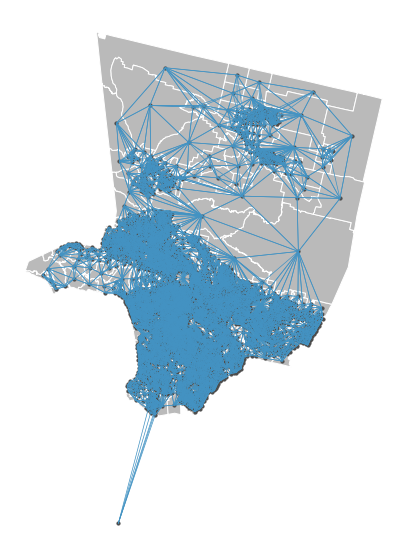

In [10]:
v.show_weights_connection(k=5, type="union")

![Lakefire Queens and Knn spatial weights](./lakefire_union_weights.png)

## LISA

In [7]:
v.lisa(k=5, type="union")

c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [8]:
from VASA.scatter import Scatter
sc = Scatter(v)

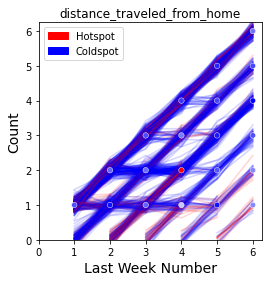

In [11]:
sc.plot(group=True, add_noise=True)

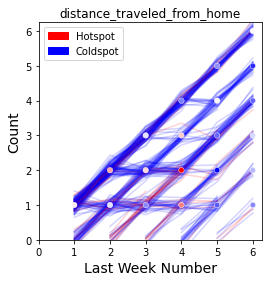

In [12]:
# one line per census tract ~1,000 census tracts still (~6500 cbgs)
# census track value is created by mode of weekly value of the the cbgs in the tract
sc.plot(group=True, add_noise=True, samples=500)

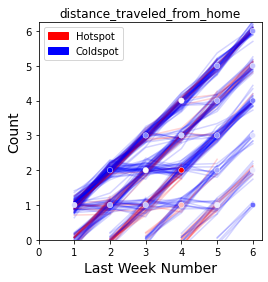

In [13]:
sc.plot(group=True, add_noise=True, samples=500)

Number of samples: 100
(100, 3)
Number of samples: 150
(150, 3)
Number of samples: 250
(250, 3)
Number of samples: 500
(500, 3)
Number of samples: 750
(750, 3)
Number of samples: 1000
(1000, 3)


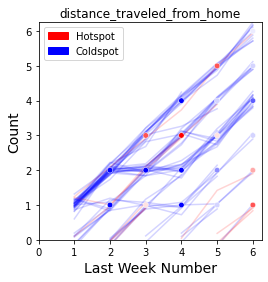

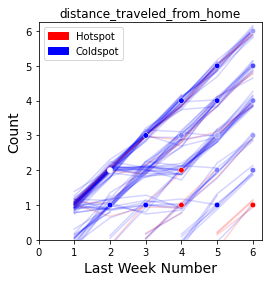

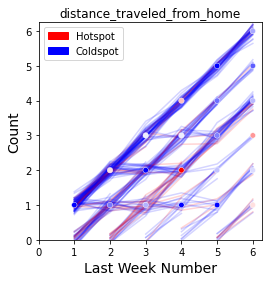

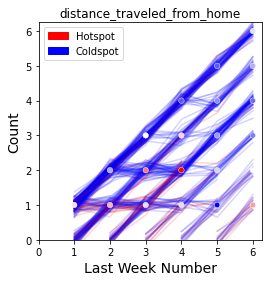

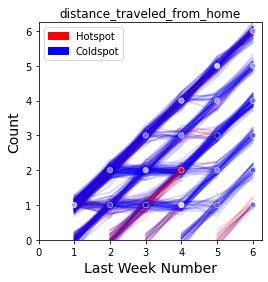

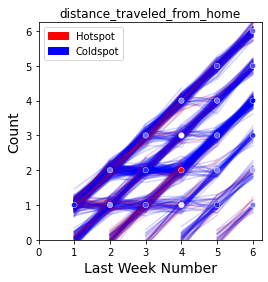

In [122]:
for sample in [100, 150, 250, 500, 750, 1000]:
    print(f"Number of samples: {sample}")
    sc.plot(highlight = "06037", samples=sample, add_noise=True)

(6581, 3)


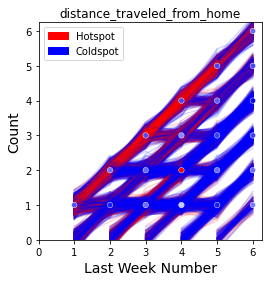

In [12]:
# Highlight values in LA County:
sc.plot(highlight = "06037", add_noise=True)

In [23]:
from VASA.static_choropleth import StackedChoropleth
stcked = StackedChoropleth(v, titles="Distance Traveled From Home")

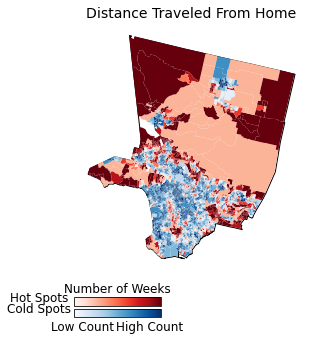

In [24]:
stcked.plot_count()

In [ ]:
stcked.plot_count(show=False)

![Lakefire count stacked choropleth](./stacked/number_of_weeks/distance_traveled_from_home.png)

In [19]:
stcked.plot_recent(show=False)

![](./stacked/recency/distance_traveled_from_home.png)

In [20]:
stcked.plot_both(a=250, b=75, show=False)

![Lakefire combined stacked choropleth](./stacked/combined/distance_traveled_from_home.png)

In [18]:
stcked.plot_bivar(show=False)

![Lakefire bivar stacked choropleth](./stacked/bivar/distance_traveled_from_home.png)